# Bachelor Data Understanding

## Imports

In [1]:
import os
# Move to Thesis directory (two levels up)
os.chdir(os.path.abspath(os.path.join("..", "..")))

# Move to model/src if it exists
model_dir = os.path.join(os.getcwd(), "model", "src")
if os.path.exists(model_dir):
    os.chdir(model_dir)

print("Current Directory:", os.getcwd())

Current Directory: c:\Users\1176153\Downloads\github\Thesis\model\src


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize



In [3]:
import libs.data_understanding as du
import libs.data_handeling as dh

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\1176153\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
c:\Users\1176153\Downloads\github\Thesis\my_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Reading the bachelor files

In [8]:
bachelor_folder_path = r"..\..\data\Preprocessing_text\all_programs_textfiles_raw\dict_bachelors_raw.pkl"
bachelor_data_raw = dh.load_pickle_to_dict(bachelor_folder_path)
bachelor_data_raw

{'bachelor_data-science_main_course_text.txt': {'text': "In the Bachelor´s Degree in Data Science, students learn the most modern techniques of artificial intelligence and machine learning to analyze large volumes of data (Big Data).\nThey will become true data scientists - considered the sexiest profession of the 21\nst\ncentury by the Harvard Business Review.\nThe main objective of this course is to train future professionals capable of understanding, developing and using models, algorithms and the most advanced techniques in data science, to analyze and extract knowledge from Big Data.\nThe 3\nrd\nphase of applications under the International Student Statute for the 2025/26 academic year are open from February 26\nth\nto March 27\nth\n, 2025.\nDuration\n3 years (6 semesters)\nTimetable\nDaytime\nStart\nSeptember 2025\nCareer Opportunities\nThe Bachelor´s Degree in Data Science allows a quick integration in the most varied sectors of activity, namely: Information Technology Companies

In [16]:
# Lists all file names stored
print(bachelor_data_raw.keys())  

dict_keys(['bachelor_data-science_main_course_text.txt', 'bachelor_data-science_studyplan_text.txt', 'bachelor_data-science_teaching-staff_text.txt', 'bachelor_information-management_main_course_text.txt', 'bachelor_information-management_studyplan_text.txt', 'bachelor_information-management_teaching-staff_text.txt', 'bachelor_information-systems_main_course_text.txt', 'bachelor_information-systems_studyplan_text.txt', 'bachelor_information-systems_teaching-staff_text.txt'])


### General Stats 
- Number of characters, words, and sentences in each text file

# Bachelor Data Science 

In [5]:
data_science_main_course = ["data-science_main_course_extracted_text.txt"]
data_science_program = ["data-science_program_extracted_text.txt"]
data_science_teaching_staff = ["data-science_teaching-staff_extracted_text.txt"]

## *data-science_main_course_extracted_text.txt*

### Word Frequency

In [9]:
import plotly.express as px
from typing import Dict, Optional, List

def histogram_word_count_multiple_docs(
    data: Dict[str, Dict],
    bins: int = 10,
    course_names_to_include: Optional[List[str]] = None,
    doc_types_to_include: Optional[List[str]] = None
):
    """
    Plots a histogram of word counts from a dict of documents with metadata.

    Parameters:
    - data (dict): Dictionary with filenames as keys and dicts containing 'text' and 'metadata'.
    - bins (int): Number of bins for the histogram.
    - course_names_to_include (list, optional): Filter by specific course names (case insensitive).
    - doc_types_to_include (list, optional): Filter by document types ('teaching_staff', 'study_plan', 'main_info').
    """

    filtered_data = {}

    for filename, doc in data.items():
        course_name = doc["metadata"].get("course_name", "").lower()
        doc_type = doc["metadata"].get("doc_type", "").lower()

        if course_names_to_include:
            if course_name not in [name.lower() for name in course_names_to_include]:
                continue

        if doc_types_to_include:
            if doc_type not in [dt.lower() for dt in doc_types_to_include]:
                continue

        filtered_data[filename] = doc

    if not filtered_data:
        print("⚠️ No documents matched the filters.")
        return

    word_counts = [len(doc["text"].split()) for doc in filtered_data.values()]
    labels = [f"{doc['metadata'].get('course_name')} ({doc['metadata'].get('doc_type')})" for doc in filtered_data.values()]

    fig = px.histogram(
        x=word_counts,
        nbins=bins,
        labels={'x': 'Word Count', 'y': 'Number of Documents'},
        title='Distribution of Documents by Word Count'
    )

    fig.update_layout(
        xaxis_title="Word Count",
        yaxis_title="Number of Documents",
        bargap=0.1
    )

    fig.show()


In [10]:
# Plot only teaching staff docs for a course
histogram_word_count_multiple_docs(
    bachelor_data_raw,
    course_names_to_include=["Data Science"]
)

In [11]:
from typing import Dict, Optional, List
import plotly.express as px
import tiktoken

def histogram_token_count_multiple_docs(
    data: Dict[str, Dict],
    model: str = "gpt-4",
    bins: int = 15,
    course_names_to_include: Optional[List[str]] = None,
    doc_types_to_include: Optional[List[str]] = None,
):
    """
    Plots a histogram of token counts per document using Plotly with optional filters.
    
    Parameters:
    - data (dict): Dictionary with filenames as keys and values as dicts with 'text' and 'metadata'.
    - model (str): OpenAI model name (e.g., "gpt-4", "gpt-3.5-turbo").
    - bins (int): Number of bins for the histogram.
    - course_names_to_include (list): Optional list of course names to include.
    - doc_types_to_include (list): Optional list of document types to include.
    """
    # Load tokenizer
    encoding = tiktoken.encoding_for_model(model)

    # Apply filters
    filtered_items = []
    for filename, doc in data.items():
        metadata = doc.get("metadata", {})
        course_name = metadata.get("course_name", "")
        doc_type = metadata.get("doc_type", "")

        if course_names_to_include and course_name not in course_names_to_include:
            continue
        if doc_types_to_include and doc_type not in doc_types_to_include:
            continue

        filtered_items.append((filename, doc["text"]))

    if not filtered_items:
        print("⚠️ No documents matched the filters.")
        return

    # Compute token counts
    token_counts = {
        filename: len(encoding.encode(text))
        for filename, text in filtered_items
    }

    # Plot
    fig = px.histogram(
        x=list(token_counts.values()),
        nbins=bins,
        labels={'x': 'Token Count', 'y': 'Number of Documents'},
        title='Distribution of Documents by Token Count'
    )

    fig.update_layout(
        xaxis_title="Token Count",
        yaxis_title="Number of Documents",
        bargap=0.1
    )

    fig.show()


In [12]:
# Plot only teaching staff docs for a course
histogram_token_count_multiple_docs(
    bachelor_data_raw,
    course_names_to_include=["Data Science"]

)

### Keywords

--- Keywords in data-science_main_course_extracted_text.txt ---
2024, 2025, 69, 70, academic, bachelor, course, data, degree, fee, installment, nova, payment, science, st, student, students, th, tuition, year


c:\Users\1176153\Downloads\github\Thesis\model\src\libs\data_understanding.py:140: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=list(keywords), y=tfidf_matrix.sum(axis=0).A1, palette="Greens_r")
c:\Users\1176153\Downloads\github\Thesis\model\src\libs\data_understanding.py:146: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(keywords, rotation=45)


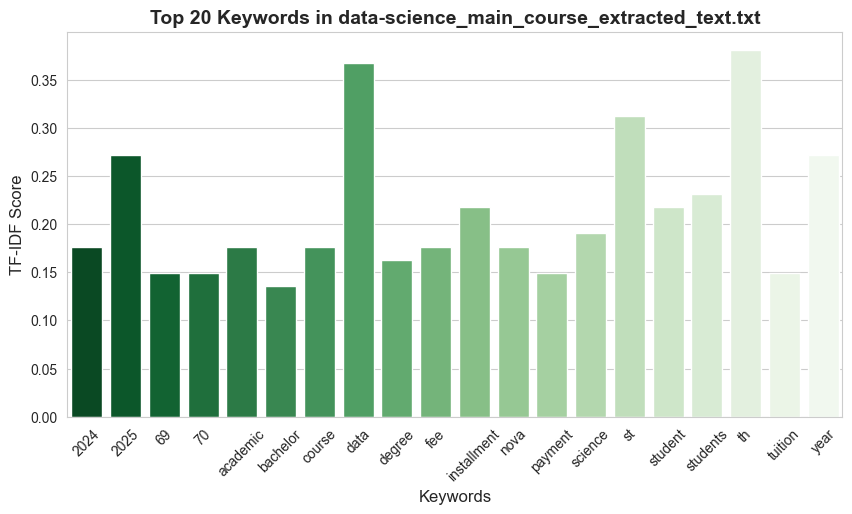

In [ ]:
du.visualize_keywords(bachelor_text_data, data_science_main_course, top_n=20)

## *data-science_program_extracted_text.txt*

### Word Frequency

c:\Users\1176153\Downloads\github\Thesis\model\src\libs\data_understanding.py:96: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=list(words), y=list(frequencies), palette="Blues_r")
c:\Users\1176153\Downloads\github\Thesis\model\src\libs\data_understanding.py:102: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(words, rotation=45)


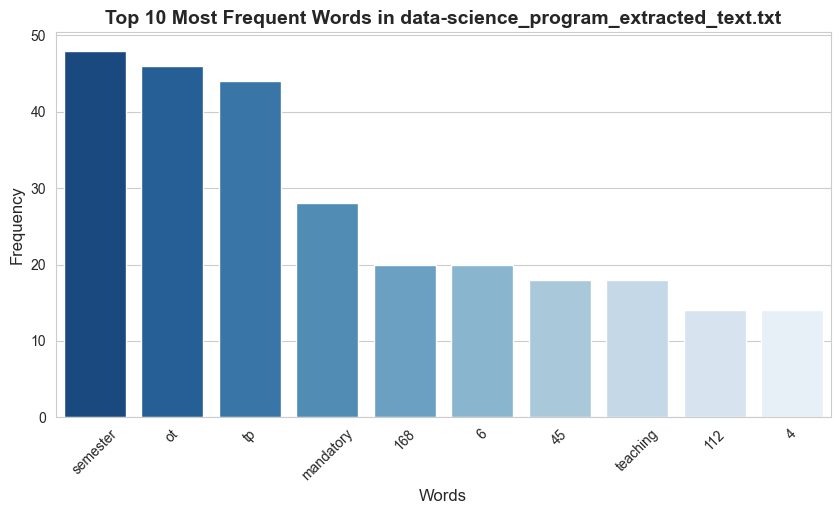

In [ ]:
selected_files = ["data-science_program_extracted_text.txt"]
du.visualize_word_frequencies(bachelor_text_data, data_science_program, top_n=10)

### Keywords

--- Keywords in data-science_program_extracted_text.txt ---
112, 168, 22, 45, 67, analysis, course, data, elective, mandatory, ot, pl, practical, semester, seminar, tc, teaching, theoretical, tp, unit


c:\Users\1176153\Downloads\github\Thesis\model\src\libs\data_understanding.py:140: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=list(keywords), y=tfidf_matrix.sum(axis=0).A1, palette="Greens_r")
c:\Users\1176153\Downloads\github\Thesis\model\src\libs\data_understanding.py:146: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(keywords, rotation=45)


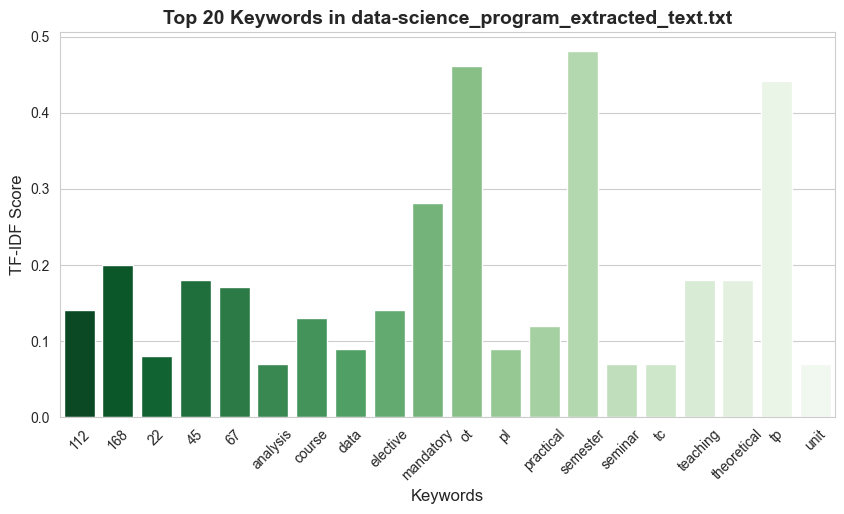

In [ ]:
selected_files = ["data-science_program_extracted_text.txt"]
du.visualize_keywords(bachelor_text_data, data_science_program, top_n=20)

## *data-science_teaching-staff_extracted_text.txt*

### Word Frequency

c:\Users\1176153\Downloads\github\Thesis\model\src\libs\data_understanding.py:96: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=list(words), y=list(frequencies), palette="Blues_r")
c:\Users\1176153\Downloads\github\Thesis\model\src\libs\data_understanding.py:102: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(words, rotation=45)


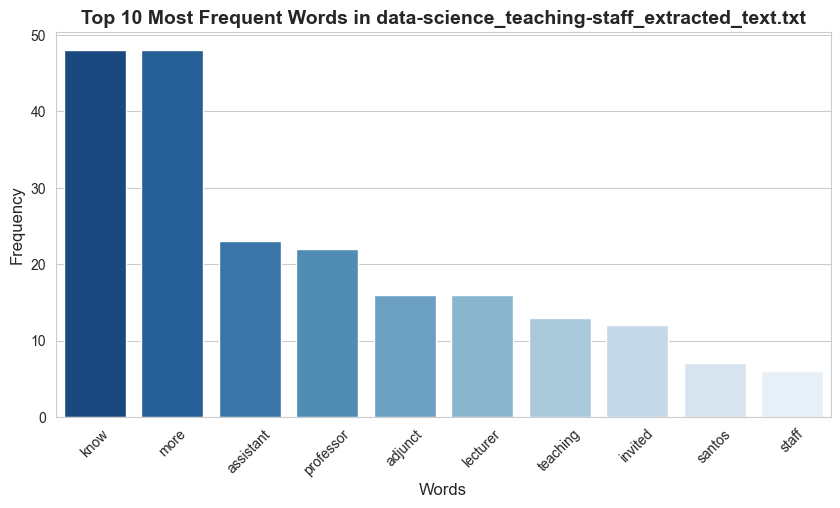

In [9]:
du.visualize_word_frequencies(bachelor_text_data, data_science_teaching_staff, top_n=10)

### Keywords

--- Keywords in data-science_teaching-staff_extracted_text.txt ---
adjunct, assistant, carolina, cristina, fernandes, invited, know, lecturer, manuela, marisa, neves, novaims, practice, professor, pt, research, santos, staff, teaching, unl


c:\Users\1176153\Downloads\github\Thesis\model\src\libs\data_understanding.py:140: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=list(keywords), y=tfidf_matrix.sum(axis=0).A1, palette="Greens_r")
c:\Users\1176153\Downloads\github\Thesis\model\src\libs\data_understanding.py:146: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(keywords, rotation=45)


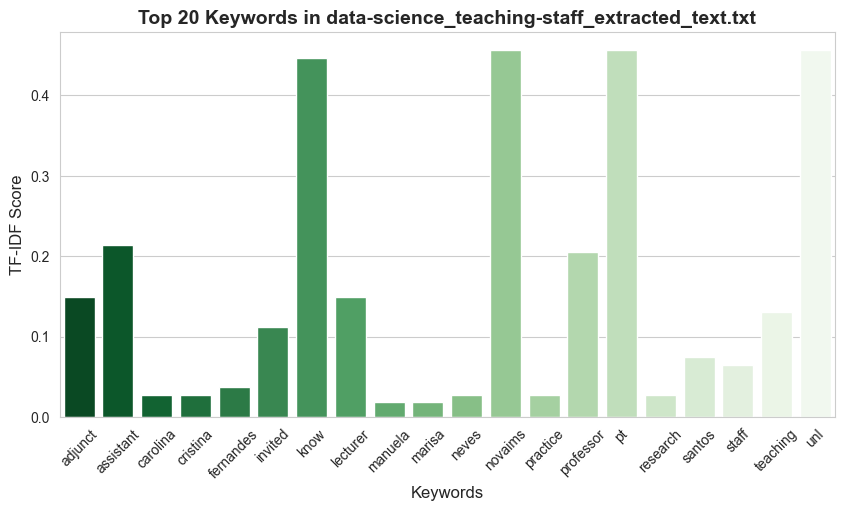

In [10]:
du.visualize_keywords(bachelor_text_data, data_science_teaching_staff, top_n=20)

# Bachelor Information Management

In [23]:
information_management_main_course = ["information-management_main_course_extracted_text.txt"]
information_management_program = ["information-management_program_extracted_text.txt"]
information_management_teaching_staff = ["information-management_teaching-staff_extracted_text.txt"]

## *information_management_main_course_extracted_text.txt*

### Word Frequency

c:\Users\1176153\Downloads\github\Thesis\model\src\libs\data_understanding.py:96: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=list(words), y=list(frequencies), palette="Blues_r")
c:\Users\1176153\Downloads\github\Thesis\model\src\libs\data_understanding.py:102: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(words, rotation=45)


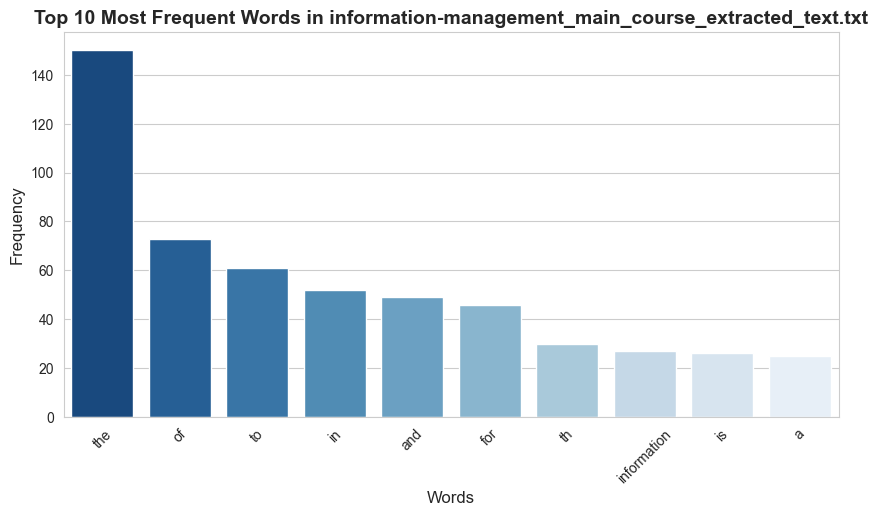

In [16]:
du.visualize_word_frequencies(bachelor_text_data, information_management_main_course, top_n=10)

### Keywords

--- Keywords in information-management_main_course_extracted_text.txt ---
2024, 2025, 69, 70, academic, course, degree, fee, information, installment, management, nova, payment, portuguese, st, student, students, th, tuition, year


c:\Users\1176153\Downloads\github\Thesis\model\src\libs\data_understanding.py:140: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=list(keywords), y=tfidf_matrix.sum(axis=0).A1, palette="Greens_r")
c:\Users\1176153\Downloads\github\Thesis\model\src\libs\data_understanding.py:146: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(keywords, rotation=45)


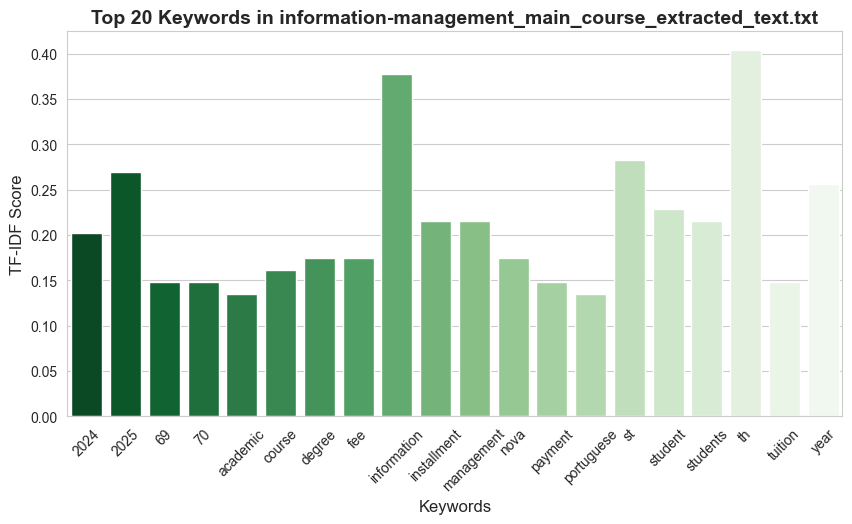

In [17]:
du.visualize_keywords(bachelor_text_data, information_management_main_course, top_n=20)

## *information_management_program_extracted_text.txt"*

### Word Frequency

c:\Users\1176153\Downloads\github\Thesis\model\src\libs\data_understanding.py:96: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=list(words), y=list(frequencies), palette="Blues_r")
c:\Users\1176153\Downloads\github\Thesis\model\src\libs\data_understanding.py:102: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(words, rotation=45)


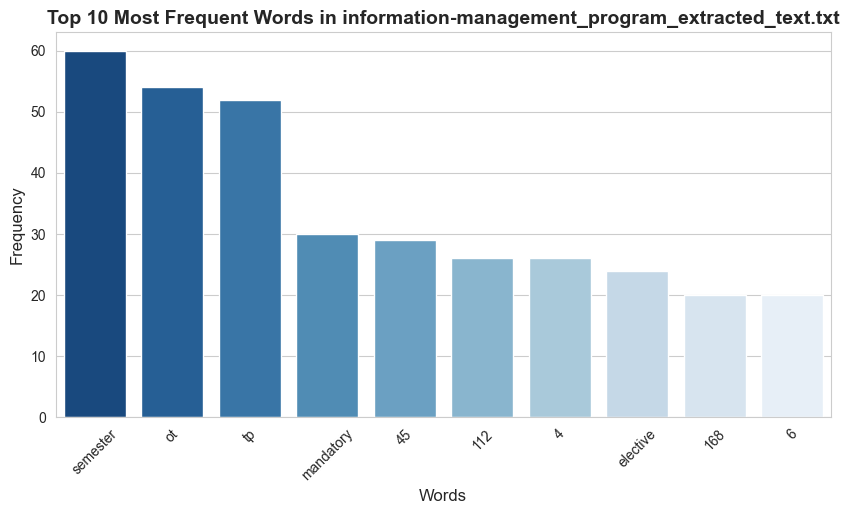

In [24]:
du.visualize_word_frequencies(bachelor_text_data, information_management_program, top_n=10)

### Keywords

--- Keywords in information-management_program_extracted_text.txt ---
112, 168, 22, 45, 67, analysis, business, course, elective, information, management, mandatory, ot, pl, practical, semester, tc, teaching, theoretical, tp


c:\Users\1176153\Downloads\github\Thesis\model\src\libs\data_understanding.py:140: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=list(keywords), y=tfidf_matrix.sum(axis=0).A1, palette="Greens_r")
c:\Users\1176153\Downloads\github\Thesis\model\src\libs\data_understanding.py:146: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(keywords, rotation=45)


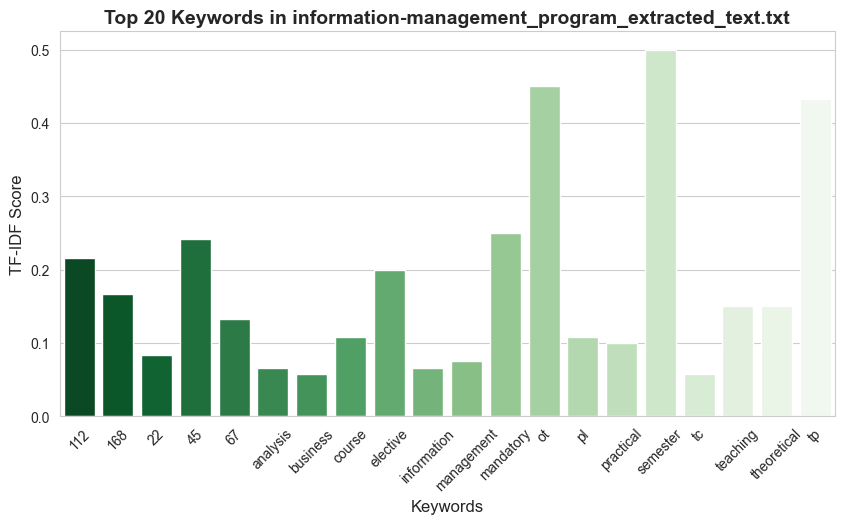

In [ ]:
du.visualize_keywords(bachelor_text_data, information_management_program, top_n=20)

## *information_management_teaching-staff_extracted_text.txt*

### Words Frequency

c:\Users\1176153\Downloads\github\Thesis\model\src\libs\data_understanding.py:96: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=list(words), y=list(frequencies), palette="Blues_r")
c:\Users\1176153\Downloads\github\Thesis\model\src\libs\data_understanding.py:102: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(words, rotation=45)


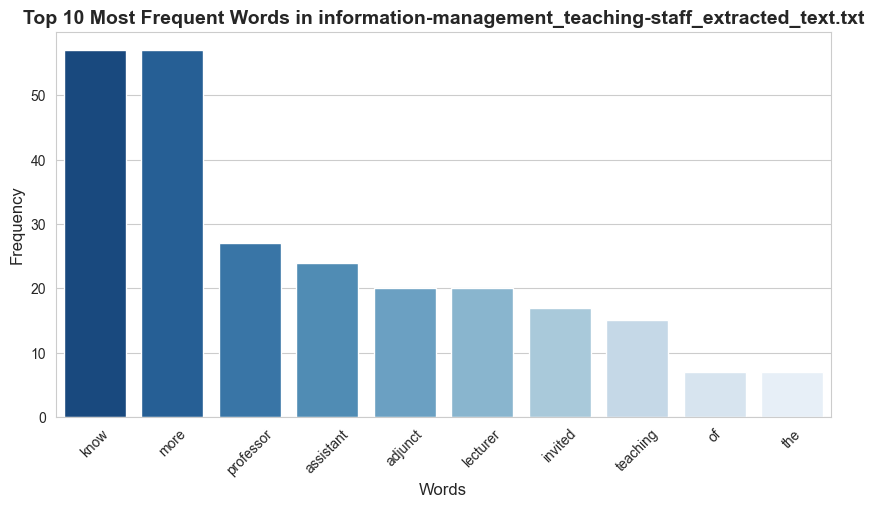

In [26]:
du.visualize_word_frequencies(bachelor_text_data, information_management_teaching_staff, top_n=10)

### Keywords

--- Keywords in information-management_teaching-staff_extracted_text.txt ---
adjunct, assistant, invited, know, lecturer, novaims, professor, pt, teaching, unl


c:\Users\1176153\Downloads\github\Thesis\model\src\libs\data_understanding.py:140: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=list(keywords), y=tfidf_matrix.sum(axis=0).A1, palette="Greens_r")
c:\Users\1176153\Downloads\github\Thesis\model\src\libs\data_understanding.py:146: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(keywords, rotation=45)


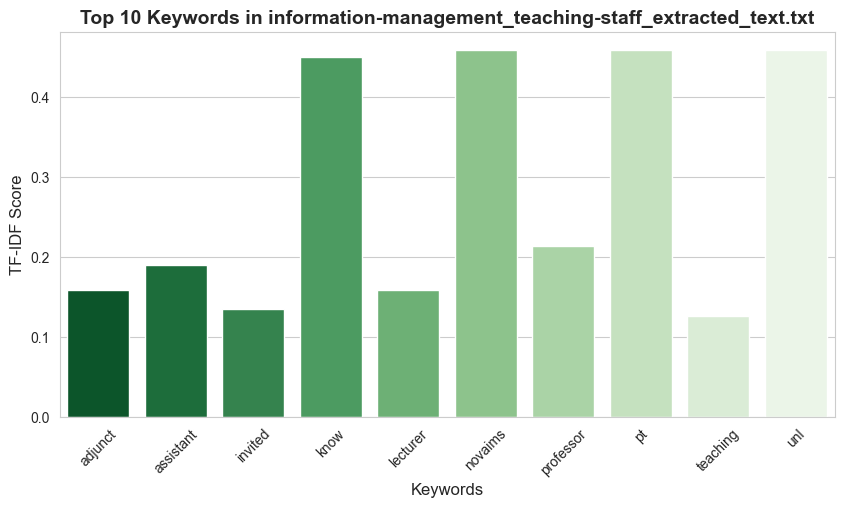

In [27]:
du.visualize_keywords(bachelor_text_data, information_management_teaching_staff, top_n=10)

# Bachelor Information Systems

In [30]:
information_systems_main_course = ["information-systems_main_course_extracted_text.txt"]
information_systems_program = ["information-systems_program_extracted_text.txt"]
information_systems_teaching_staff = ["information-systems_teaching-staff_extracted_text.txt"]

## *information_systems_main_course_extracted_text.txt*

### Word Frequency

c:\Users\1176153\Downloads\github\Thesis\model\src\libs\data_understanding.py:96: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=list(words), y=list(frequencies), palette="Blues_r")
c:\Users\1176153\Downloads\github\Thesis\model\src\libs\data_understanding.py:102: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(words, rotation=45)


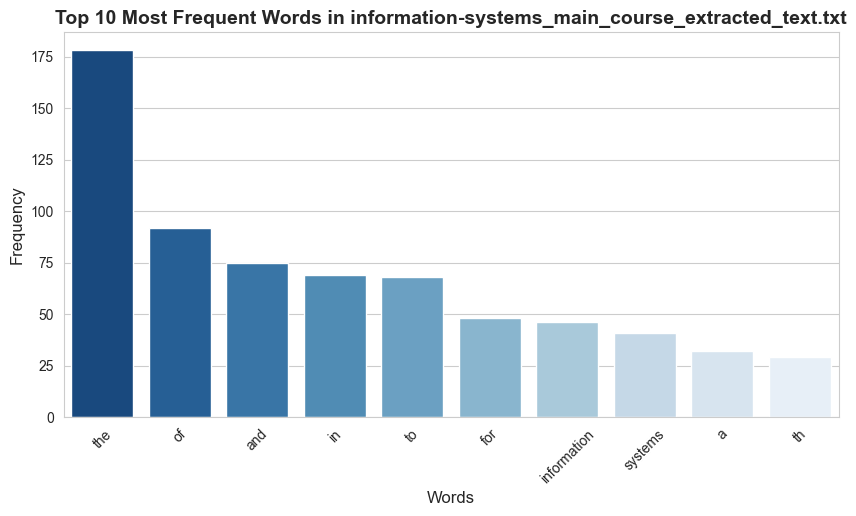

In [31]:
du.visualize_word_frequencies(bachelor_text_data, information_systems_main_course, top_n=10)

### Keywords

--- Keywords in information-systems_main_course_extracted_text.txt ---
2025, academic, degree, information, st, student, students, systems, th, year


c:\Users\1176153\Downloads\github\Thesis\model\src\libs\data_understanding.py:140: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=list(keywords), y=tfidf_matrix.sum(axis=0).A1, palette="Greens_r")
c:\Users\1176153\Downloads\github\Thesis\model\src\libs\data_understanding.py:146: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(keywords, rotation=45)


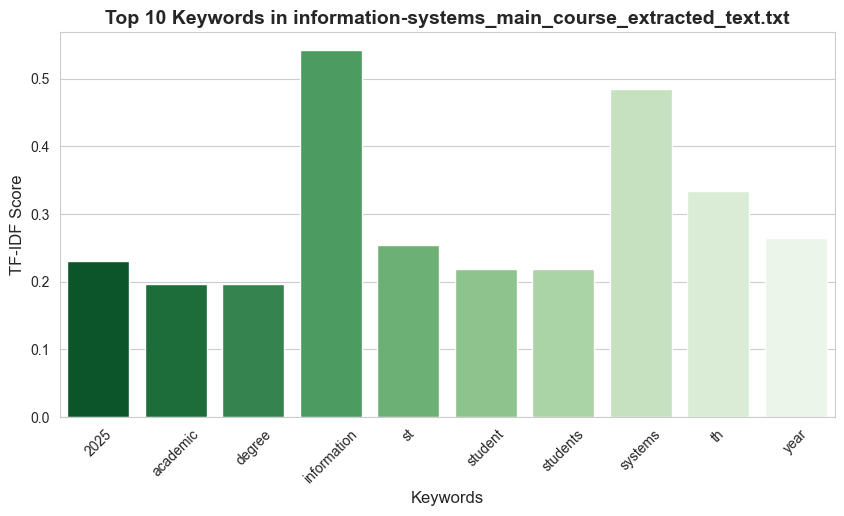

In [32]:
du.visualize_keywords(bachelor_text_data, information_systems_main_course, top_n=10)

## *information_systems_program_extracted_text.txt*

### Word Frequency

c:\Users\1176153\Downloads\github\Thesis\model\src\libs\data_understanding.py:96: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=list(words), y=list(frequencies), palette="Blues_r")
c:\Users\1176153\Downloads\github\Thesis\model\src\libs\data_understanding.py:102: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(words, rotation=45)


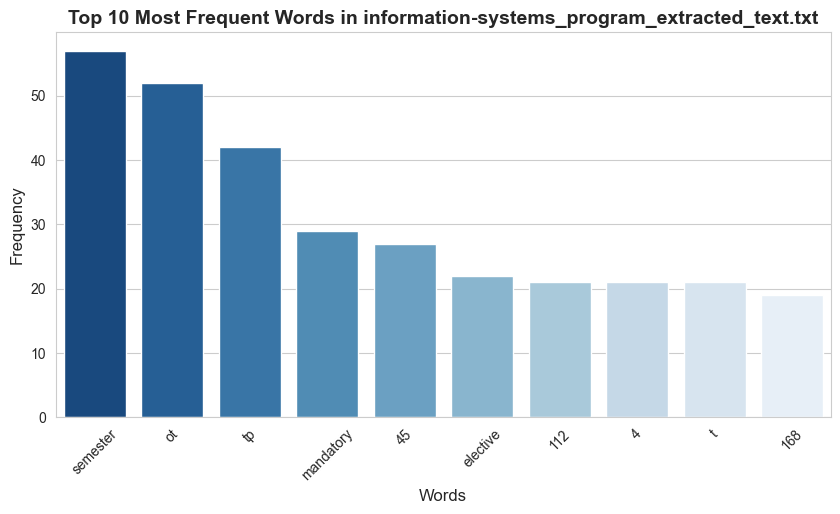

In [33]:
du.visualize_word_frequencies(bachelor_text_data, information_systems_program, top_n=10)

### Keywords

--- Keywords in information-systems_program_extracted_text.txt ---
112, 168, 45, elective, mandatory, ot, semester, teaching, theoretical, tp


c:\Users\1176153\Downloads\github\Thesis\model\src\libs\data_understanding.py:140: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=list(keywords), y=tfidf_matrix.sum(axis=0).A1, palette="Greens_r")
c:\Users\1176153\Downloads\github\Thesis\model\src\libs\data_understanding.py:146: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(keywords, rotation=45)


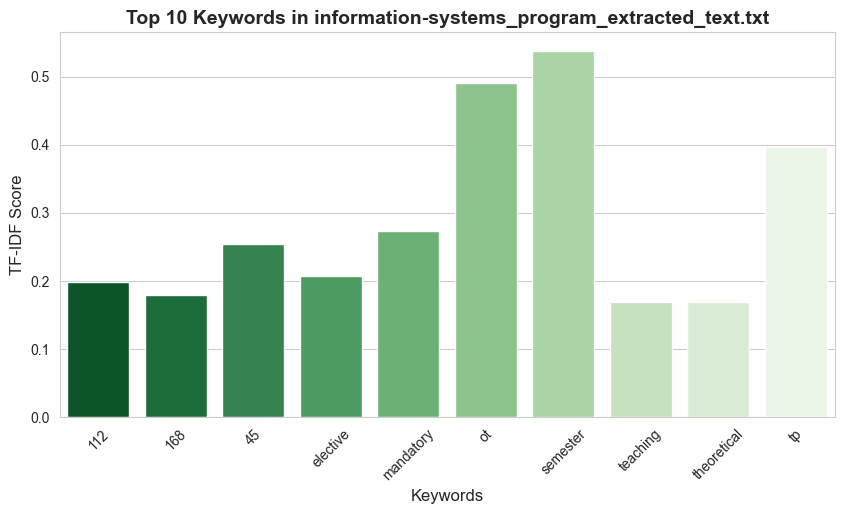

In [34]:
du.visualize_keywords(bachelor_text_data, information_systems_program, top_n=10)

## *information_systems_teaching-staff_extracted_text.txt*

### Word Frequency

c:\Users\1176153\Downloads\github\Thesis\model\src\libs\data_understanding.py:96: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=list(words), y=list(frequencies), palette="Blues_r")
c:\Users\1176153\Downloads\github\Thesis\model\src\libs\data_understanding.py:102: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(words, rotation=45)


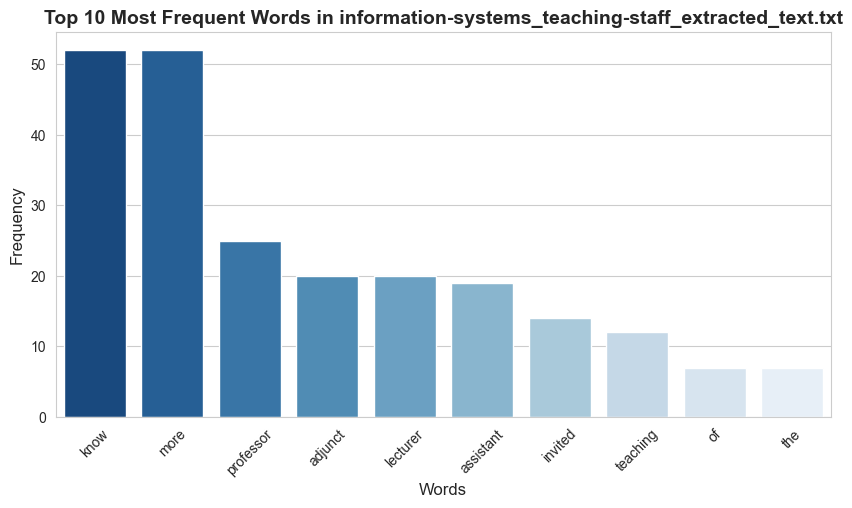

In [35]:
du.visualize_word_frequencies(bachelor_text_data, information_systems_teaching_staff, top_n=10)

### Keywords

--- Keywords in information-systems_teaching-staff_extracted_text.txt ---
adjunct, assistant, invited, know, lecturer, novaims, professor, pt, teaching, unl


c:\Users\1176153\Downloads\github\Thesis\model\src\libs\data_understanding.py:140: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=list(keywords), y=tfidf_matrix.sum(axis=0).A1, palette="Greens_r")
c:\Users\1176153\Downloads\github\Thesis\model\src\libs\data_understanding.py:146: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(keywords, rotation=45)


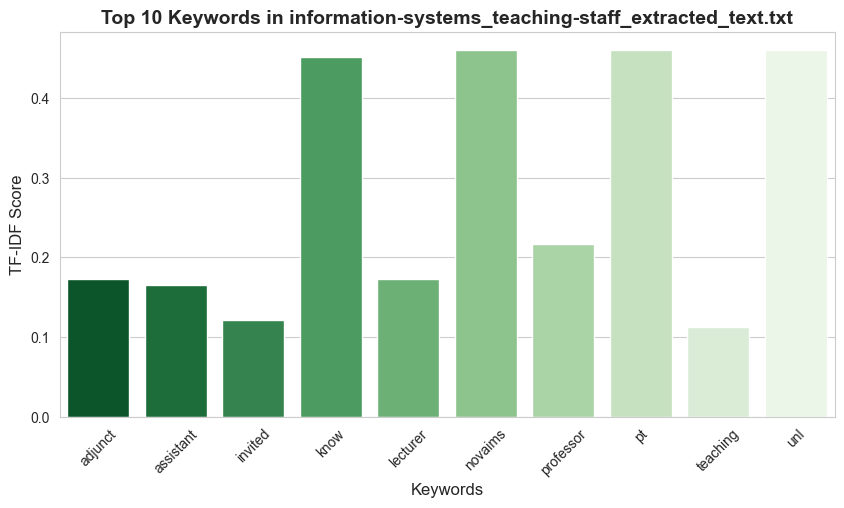

In [36]:
du.visualize_keywords(bachelor_text_data, information_systems_teaching_staff, top_n=10)

# Saving the txt files in dictionaries 

In [5]:
dict_maincourse_raw = {}
dict_studyplan_raw = {}
dict_teachingstaff_raw = {}

for key, value in bachelor_text_data.items():
    if "main_course" in key:
        dict_maincourse_raw[key] = value
    elif "program_extracted" in key:
        dict_studyplan_raw[key] = value
    elif "teaching-staff" in key:
        dict_teachingstaff_raw[key] = value

# Now you have three separate dictionaries
print("Main Course Keys:", dict_maincourse_raw.keys())
print("Program Extracted Keys:", dict_studyplan_raw.keys())
print("Teaching Staff Keys:", dict_teachingstaff_raw.keys())

Main Course Keys: dict_keys(['data-science_main_course_extracted_text.txt', 'information-management_main_course_extracted_text.txt', 'information-systems_main_course_extracted_text.txt'])
Program Extracted Keys: dict_keys(['data-science_program_extracted_text.txt', 'information-management_program_extracted_text.txt', 'information-systems_program_extracted_text.txt'])
Teaching Staff Keys: dict_keys(['data-science_teaching-staff_extracted_text.txt', 'information-management_teaching-staff_extracted_text.txt', 'information-systems_teaching-staff_extracted_text.txt'])


In [ ]:
import pickle 
# Define output folder
output_folder = "../../data/Webscrapping/bachelor_dict_textfiles_raw"

os.makedirs(output_folder, exist_ok=True)  # Ensure output folder exists

# Save each dictionary as a separate Pickle file
with open(os.path.join(output_folder, "dict_teachingstaff_raw.pkl"), "wb") as f:
    pickle.dump(dict_teachingstaff_raw, f)

with open(os.path.join(output_folder, "dict_studyplan_raw.pkl"), "wb") as f:
    pickle.dump(dict_studyplan_raw, f)

with open(os.path.join(output_folder, "dict_maininfo_raw.pkl"), "wb") as f:
    pickle.dump(dict_maincourse_raw, f)


print("Pickle files saved successfully!")

Pickle files saved successfully!
